# Banzhaf Values for data valuation

Similar to the Shapley values notebook, this notebook shows how to compute Banzhaf values using pyDVL.
Banzhaf semivalues achieve a higher safety margin when compared with other methods like Shapley or LOO semivalues.

This notebook compares two sampling techniques for computing Banzhaf semivalues, a simple Monte Carlo sampling technique
and another sampling technique using the MSR (Maximum Sample Reuse) principle. We also compare both techniques in this notebook.

In this notebook, we will use a CNN to classify handwritten digits from the [scikit-learn toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
n_jobs = 16
random.seed(random_state)

We will be using the following functions from pyDVL. The main entry point is the function `compute_banzhaf_semivalues()`.
In order to use it we need the classes [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset), [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility) and [Scorer](../../api/pydvl/utils/score/#pydvl.utils.score.Scorer).

In [3]:
%autoreload
from pydvl.reporting.plots import plot_shapley
from support.banzhaf import load_digits_dataset
from pydvl.value import *

/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(


## Loading and grouping the dataset

pyDVL provides a support function for this notebook, `load_digits_dataset()`, which downloads the data and prepares it for usage. The data consists of greyscale images of shape 8x8 pixels with 16 shades of grey. These images contain handwritten digits from 0 to 9.

In [4]:
training_data, _, test_data = load_digits_dataset(
    test_size=0.3, random_state=random_state
)

In [5]:
# In CI we only use a subset of the training set
training_data = list(training_data)
if is_CI:
    training_data[0] = training_data[0][:10]
    training_data[1] = training_data[1][:10]
    max_checks = 1
else:
    training_data[0] = training_data[0][:200]
    training_data[1] = training_data[1][:200]
    max_checks = 1000

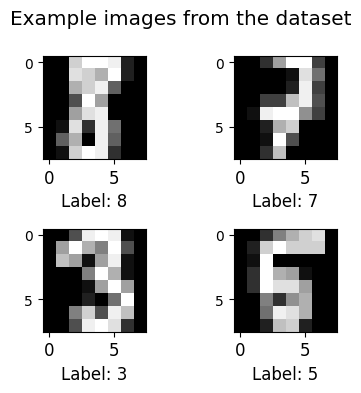

In [6]:
# Visualize some of the data
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
for i in range(4):
    ax = axes[i % 2, i // 2]
    ax.imshow(np.reshape(training_data[0][i], (8, 8)), cmap="grey")
    ax.set_xlabel(f"Label: {training_data[1][i]}")
plt.suptitle("Example images from the dataset")
plt.tight_layout()
plt.show()

Training and test data are then used to instantiate a [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset) object:

In [7]:
dataset = Dataset(*training_data, *test_data)

## Creating the utility and computing Banzhaf semivalues

Now we can calculate the contribution of each group to the model performance.

As a model, we use scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), but pyDVL can work with any model from sklearn, xgboost or lightgbm. More precisely, any model that implements the protocol [pydvl.utils.types.SupervisedModel](../../api/pydvl/utils/types/#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility.

The third and final component is the scoring function. It can be anything like accuracy or $R^2$, and is set with a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html). Please refer to that documentation on information on how to define your own scoring function.

We group dataset, model and scoring function into an instance of [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility).

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from numpy.typing import NDArray
from pydvl.utils.types import SupervisedModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TorchCNNModel(SupervisedModel):
    def __init__(self, lr=0.001, epochs=40, batch_size=32):
        self.lr = lr
        self.batch_size = batch_size
        self.model = nn.Sequential(
            nn.Conv2d(
                out_channels=8, in_channels=1, kernel_size=(3, 3), padding="same"
            ),
            nn.Conv2d(
                out_channels=4, in_channels=8, kernel_size=(3, 3), padding="same"
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=10),
            nn.Softmax(dim=1),
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.model.to(device)

    def fit(self, x: NDArray, y: NDArray) -> None:
        torch_dataset = TensorDataset(
            torch.tensor(
                np.reshape(x, (x.shape[0], 1, 8, 8)), dtype=torch.float, device=device
            ),
            torch.tensor(y, device=device),
        )
        torch_dataloader = DataLoader(torch_dataset, batch_size=self.batch_size)
        for epoch in range(self.epochs):
            for features, labels in torch_dataloader:
                pred = self.model(features)
                loss = self.loss(pred, labels)
                loss.backward()
                self.optimizer.step()

    def predict(self, x: NDArray) -> NDArray:
        pred = self.model(
            torch.tensor(
                np.reshape(x, (x.shape[0], 1, 8, 8)), dtype=torch.float, device=device
            )
        )
        pred = torch.argmax(pred, dim=1)
        return pred.cpu().numpy()

    def score(self, x: NDArray, y: NDArray) -> float:
        pred = self.predict(x)
        acc = accuracy_score(pred, y)
        return acc

    def get_params(self, deep: bool = False):
        return {"lr": self.lr, "epochs": self.epochs}


model = TorchCNNModel(lr=0.001, epochs=40)
model.fit(x=training_data[0], y=training_data[1])
print(f"Train Accuracy: {model.score(x=training_data[0], y=training_data[1]):.3f}")
print(f"Test Accuracy: {model.score(x=test_data[0], y=test_data[1]):.3f}")

Train Accuracy: 0.300
Test Accuracy: 0.081


In [9]:
# Compute regular Banzhaf semivalue
utility = Utility(
    model=TorchCNNModel(),
    data=dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
)
values = compute_banzhaf_semivalues(
    utility, done=MaxChecks(max_checks), n_jobs=n_jobs, progress=True
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` clas

Let's take a look at the returned dataframe:

In [10]:
df.head()

,data_value,data_value_stderr
0,0.0,0.0
1,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


Let us plot the results. In the next cell we will take the 30 images with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Monte Carlo Banzhaf is typically very noisy, and it can take many steps to arrive at a clean estimate.

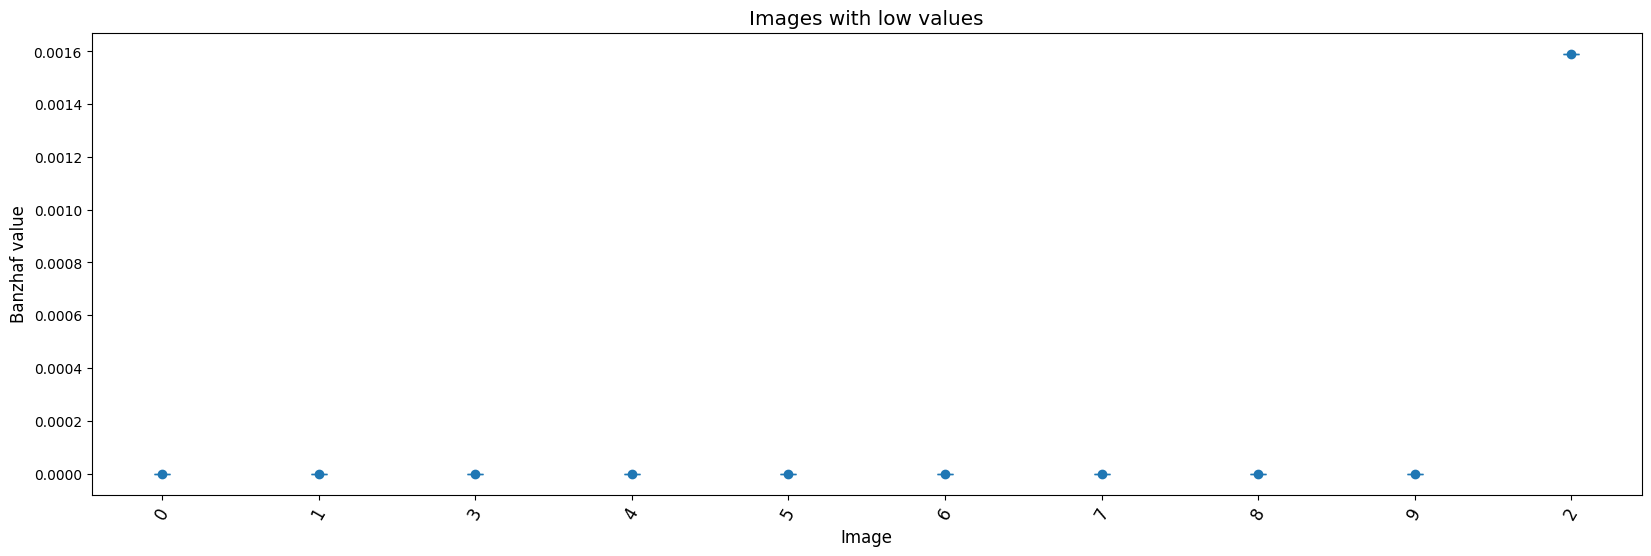

In [11]:
low_dvl = df.iloc[:30].copy()
low_dvl.index = low_dvl.index.map(str)
plot_shapley(
    low_dvl,
    level=0.05,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show()

## Evaluation on anomalous data

An interesting usecase for data valuation is finding anomalous data. Maybe some of the data is really noisy or has been mislabeled. To simulate this, we will change some of the labels of our dataset and add noise to some others. Intuitively, these anomalous data points should then have a lower value.

To evaluate this, let us first check the average value of the first 10 data points, as these will be the ones that we modify. Currently, these are the 10 data points with the highest semivalues:

In [12]:
high_dvl = df.iloc[-10:].copy()
print(f"Average value of first 10 data points: {high_dvl['data_value'].mean()}")
print(f"Exact values:\n{high_dvl['data_value']}")

Average value of first 10 data points: 0.00015914351851851853
Exact values:
0    0.000000
1    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
2    0.001591
Name: data_value, dtype: float64


For the first 5 images, we will falsify their label, for images 6-10, we will add some noise.

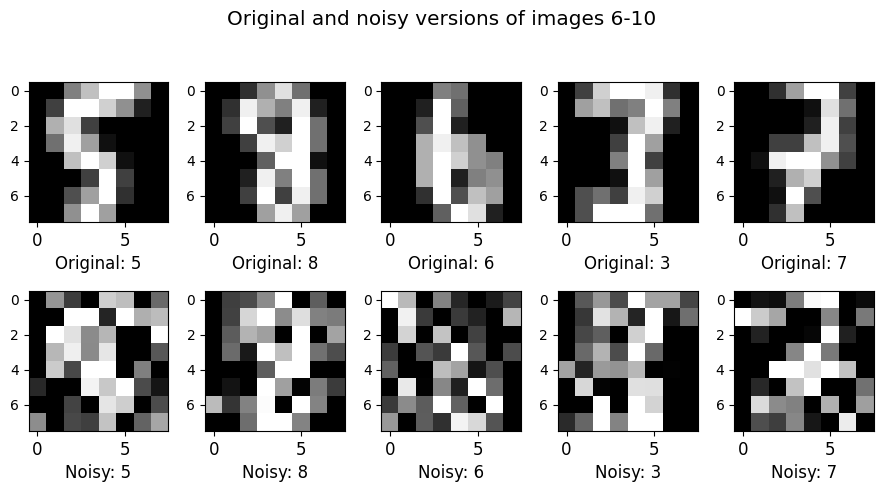

In [13]:
x_train_anomalous = training_data[0].copy()
y_train_anomalous = training_data[1].copy()
anomalous_indices = high_dvl.index.map(int).values[:10]

# Set label of first 5 images to 0
y_train_anomalous[high_dvl.index.map(int).values[:5]] = 0

# Add noise to images 6-10
indices = high_dvl.index.values[5:10].astype(int)
current_images = x_train_anomalous[indices]
noisy_images = current_images + 0.5 * np.random.randn(*current_images.shape)
noisy_images[noisy_images < 0] = 0.0
noisy_images[noisy_images > 1] = 1.0
x_train_anomalous[indices] = noisy_images

fig, axes = plt.subplots(2, 5, figsize=(9, 5))
for i in range(5):
    axes[0, i].imshow(np.reshape(current_images[i], (8, 8)), cmap="grey")
    axes[1, i].imshow(np.reshape(noisy_images[i], (8, 8)), cmap="grey")
    axes[0, i].set_xlabel(f"Original: {training_data[1][indices[i]]}")
    axes[1, i].set_xlabel(f"Noisy: {training_data[1][indices[i]]}")
plt.suptitle("Original and noisy versions of images 6-10")
plt.tight_layout()
plt.show()

In [14]:
anomalous_dataset = Dataset(
    x_train=x_train_anomalous,
    y_train=y_train_anomalous,
    x_test=test_data[0],
    y_test=test_data[1],
)

anomalous_utility = Utility(
    model=TorchCNNModel(),
    data=anomalous_dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
)
anomalous_values = compute_banzhaf_semivalues(
    anomalous_utility, done=MaxChecks(max_checks), n_jobs=n_jobs, progress=True
)
anomalous_values.sort(key="value")
anomalous_df = anomalous_values.to_dataframe(column="data_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` clas

Let us now take a look at the low-value images and check how many of our anomalous images are part of it.

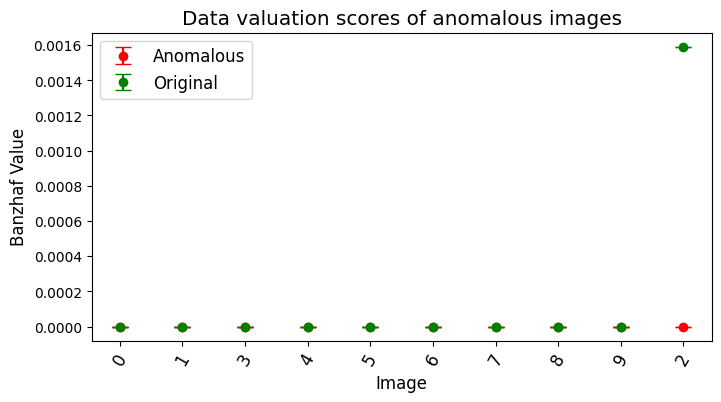

In [15]:
from scipy.stats import norm


plot_data = anomalous_df.loc[anomalous_indices].copy()
plot_data["original_data_value"] = df.loc[anomalous_indices]["data_value"]
plot_data["original_data_value_stderr"] = df.loc[anomalous_indices]["data_value_stderr"]
plot_data.index = plot_data.index.map(str)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
yerr = norm.ppf(1 - 0.05 / 2) * plot_data["data_value_stderr"]
original_yerr = norm.ppf(1 - 0.05 / 2) * plot_data["original_data_value_stderr"]
ax.errorbar(
    x=plot_data.index,
    y=plot_data["data_value"],
    yerr=yerr,
    fmt="o",
    capsize=6,
    color="red",
    label="Anomalous",
)
ax.errorbar(
    x=plot_data.index,
    y=plot_data["original_data_value"],
    yerr=original_yerr,
    fmt="o",
    capsize=6,
    color="green",
    label="Original",
)
ax.set_xlabel("Image")
ax.set_ylabel("Banzhaf Value")
ax.set_title("Data valuation scores of anomalous images")
plt.legend()
plt.xticks(rotation=60)
plt.show()

As can be seen in this figure, the valuation of the data points has decreased significantly by adding noise or falsifying their labels.
This shows the potential of using Banzhaf values or other data valuation methods to detect mislabeled data points or noisy input data.

In [16]:
print(
    f"Average value of original data points: {plot_data['original_data_value'].mean()}"
)
print(
    f"Average value of modified, anomalous data points: {plot_data['data_value'].mean()}"
)
print(
    "For reference, these are the average data values of all data points used for training (anomalous):"
)
print(anomalous_df.mean())
print("These are the average data values of all points (original data):")
print(df.mean())

Average value of original data points: 0.00015914351851851853
Average value of modified, anomalous data points: 0.0
For reference, these are the average data values of all data points used for training (anomalous):
data_value           0.0
data_value_stderr    0.0
dtype: float64
These are the average data values of all points (original data):
data_value           0.000159
data_value_stderr    0.000000
dtype: float64


### Maximum Sample Reuse Banzhaf

Now, we want to use a method called Maximum Sample Reuse (MSR) which reuses samples for updating the Banzhaf values.
The method is introduced by Wang et al. in the paper *Data Banzhaf: A Robust Data Valuation Framework for Machine Learning*.
It promises a higher sample efficiency by using a principle called Maximum Sample Reuse for sampling and updating semivalues.

In [17]:
# Compute MSR Banzhaf semivalue
utility = Utility(
    model=TorchCNNModel(),
    data=dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
)
values = compute_msr_banzhaf_semivalues(
    utility,
    done=RankStability(0.0001),
    n_jobs=n_jobs,
    progress=True,
)
values.sort(key="value")
msr_df = values.to_dataframe(column="data_value", use_names=True)

  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.p

In [18]:
msr_df.head()

,data_value,data_value_stderr
5,-0.023279,0.011563
2,-0.017708,0.011823
7,-0.009815,0.013890
4,-0.003098,0.013650
8,-0.001296,0.012168


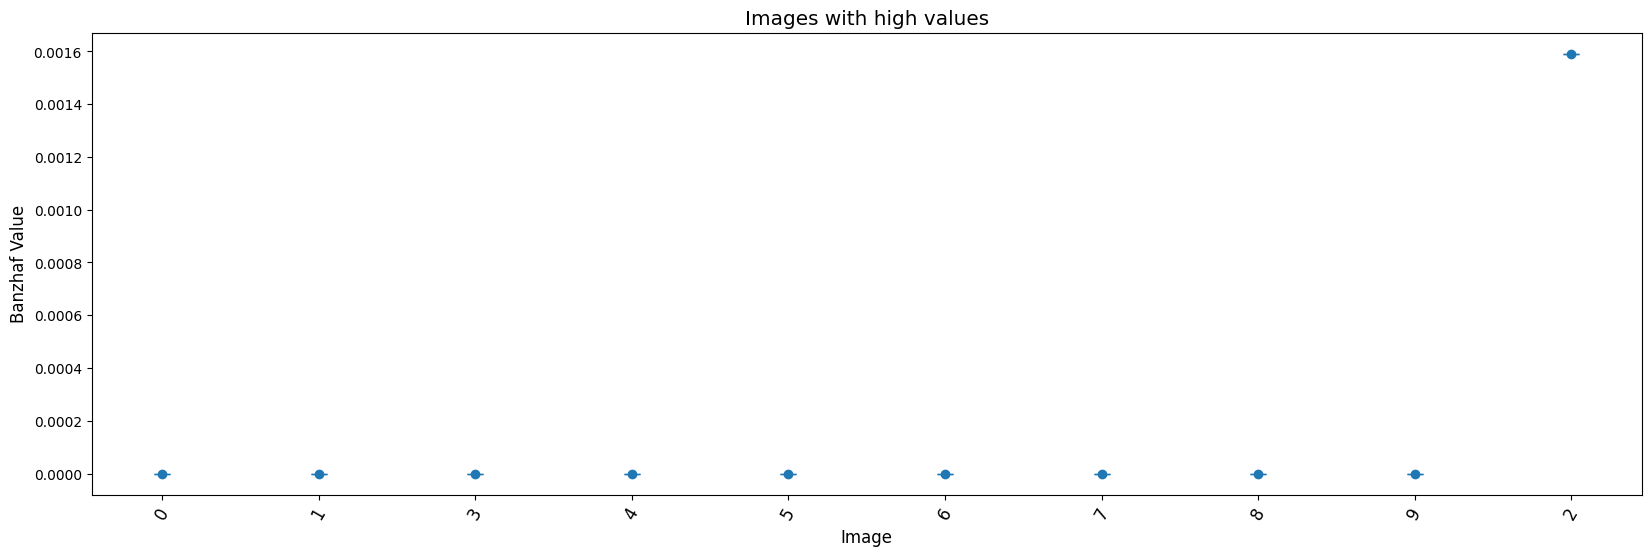

In [19]:
high_dvl = df.iloc[-30:]
high_dvl.index = high_dvl.index.map(str)
ax = plot_shapley(
    high_dvl,
    title="Images with high values",
    xlabel="Image",
    ylabel="Banzhaf Value",
)
plt.show()

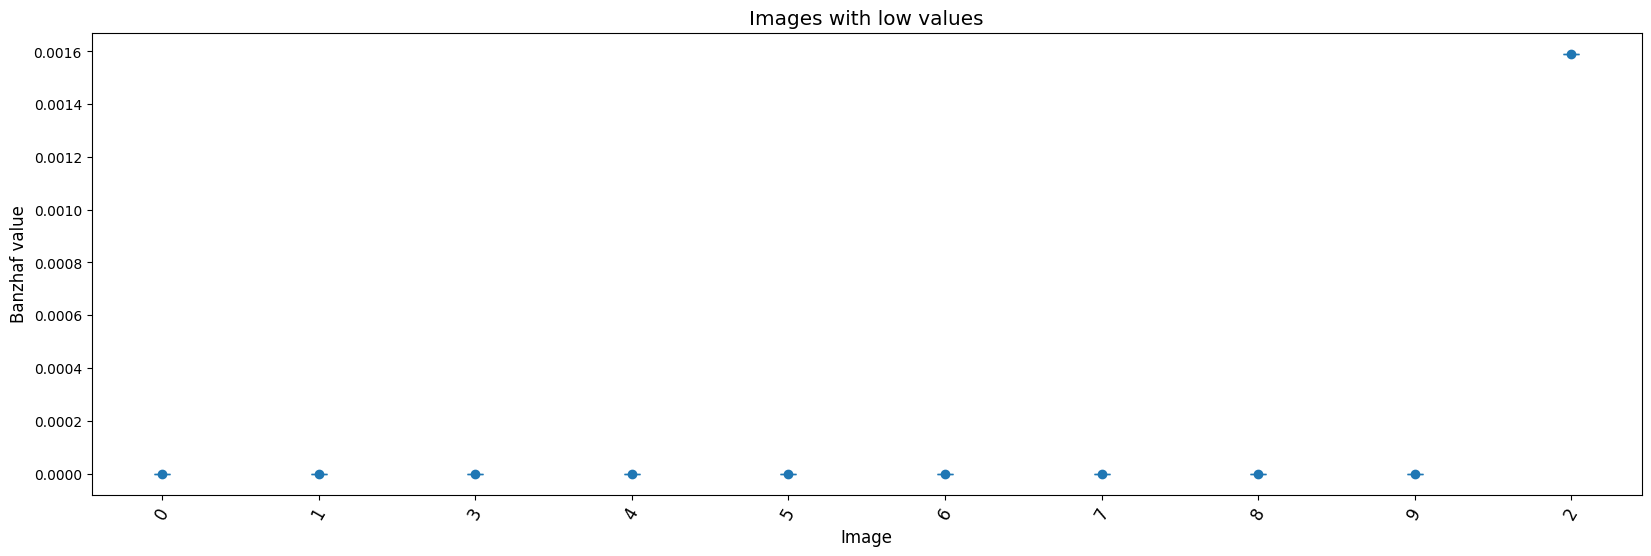

In [20]:
low_dvl = df.iloc[:30]
low_dvl.index = low_dvl.index.map(str)
ax = plot_shapley(
    low_dvl,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show()

### Compare convergence speed of Banzhaf and MSR Banzhaf Values

While the conventional Banzhaf values algorithm evaluates the utility twice to do one update of the Banzhaf values, the Maximum Samples Reuse (MSR) algorithm promises higher sample efficiency because it updates multiple samples per one evaluation of the utility. This part of the notebook takes a look at the convergence speed of the algorithms compared with each other.

In [21]:
if is_CI:
    max_checks = 1
    moving_avg = 1
else:
    max_checks = 10000
    moving_avg = 200

In [22]:
from sklearn.linear_model import SGDClassifier

if not is_CI:
    utility = Utility(
        model=TorchCNNModel(),
        data=dataset,
        scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    )
else:
    utility = Utility(
        model=SGDClassifier(max_iter=2),
        data=dataset,
        scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    )

In [23]:
def get_semivalues_and_history(
    sampler_t, num_checks=max_checks, num_jobs=n_jobs, progress=True
):
    _history = HistoryDeviation(n_steps=num_checks, rtol=1e-9)
    if sampler_t == MSRSampler:
        _values = compute_msr_banzhaf_semivalues(
            utility,
            sampler_t=sampler_t,
            done=MaxChecks(num_checks + 2) | _history,
            n_jobs=num_jobs,
            progress=progress,
        )
    else:
        _values = compute_banzhaf_semivalues(
            utility,
            done=MaxChecks(num_checks + 2) | _history,
            n_jobs=num_jobs,
            progress=progress,
        )
    return _history, _values

In [24]:
# Monte Carlo Permutation Sampling Banzhaf semivalues
history_permutation, permutation_values = get_semivalues_and_history(PermutationSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` clas

In [25]:
# MSR Banzhaf values
history_msr, msr_values = get_semivalues_and_history(MSRSampler)

  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The 

In [26]:
# UniformSampler
history_uniform, uniform_values = get_semivalues_and_history(UniformSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.

In [27]:
# AntitheticSampler
history_antithetic, antithetic_values = get_semivalues_and_history(AntitheticSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.

In [28]:
# RandomHierarchicalSampler
history_random, random_values = get_semivalues_and_history(RandomHierarchicalSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.

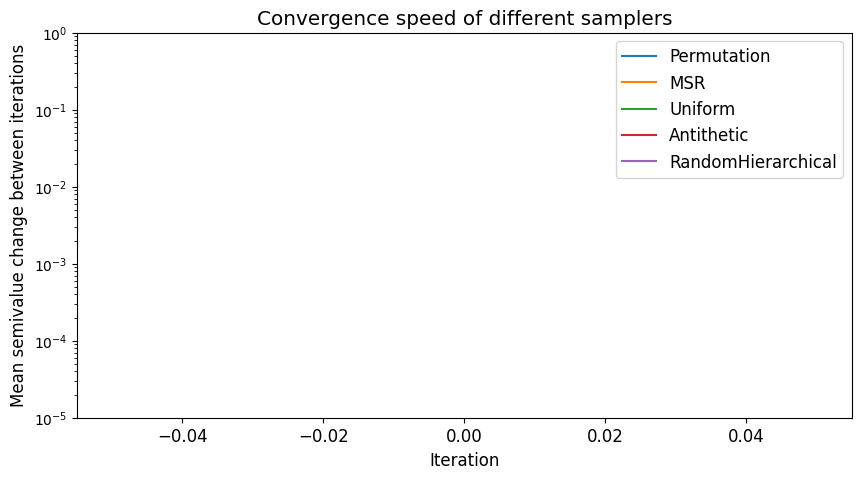

In [29]:
# Compare convergence speed of both methods
import numpy as np

names = ["Permutation", "MSR", "Uniform", "Antithetic", "RandomHierarchical"]
all_values = [
    history_permutation._memory,
    history_msr._memory,
    history_uniform._memory,
    history_antithetic._memory,
    history_random._memory,
]
distances = [[] for _ in names]
moving_avgs = []

for sampler_id, name in enumerate(names):
    for iteration in range(max_checks):
        abs_dist = np.abs(
            all_values[sampler_id][:, iteration]
            - all_values[sampler_id][:, iteration + 1]
        )
        if abs_dist.max() == 0.0:
            distances[sampler_id].append(0.0)
        else:
            distances[sampler_id].append(np.mean(abs_dist[abs_dist > 0]))
    moving_avgs.append(
        np.convolve(
            distances[sampler_id], np.ones(moving_avg) / moving_avg, mode="same"
        )
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for sampler_id, name in enumerate(names):
    ax.plot(list(range(max_checks)), moving_avgs[sampler_id], label=name)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean semivalue change between iterations")
ax.set_title("Convergence speed of different samplers")
plt.yscale("log")
plt.ylim(1e-5, 1)
plt.legend()
plt.show()

The plot above visualizes the convergence speed of different samplers used for Banzhaf semivalue calculation.  
It shows the average magnitude of how much the semivalues are updated in every step of the algorithm. 

As you can see, **MSR Banzhaf** converges much faster. 
After 1000 iterations (subsets tried), Monte Carlo Banzhaf has evaluated the marginal function about 5 times per data point (we are using 200 data points). 
For maximum sample reuse, the semivalue of each data point was updated 1000 times. Due to this, the values converge much quicker, which is one of the advantages of MSR sampling. 

MSR sampling does come at a cost, however, which we will visualize in the next plot. The semivalues that MSR converges to are less consistent.

In [30]:
from scipy.stats import spearmanr

print("Similarity of the ranking of Permutation Sampler and MSR Sampler semivalues:")
print(spearmanr(permutation_values.values, msr_values.values))

Similarity of the ranking of Permutation Sampler and MSR Sampler semivalues:
SignificanceResult(statistic=-0.1956557569612498, pvalue=0.58801436414807)


### Consistency of the semivalues

In this part, we want to analyze how consistent the semivalues returned by the different samplers are.  
To evaluate this, we will compute semivalues multiple times and check how many of the data points in the top and lowest 20% of valuation of the data overlap.

In [31]:
max_checks = [1e3, 2e3, 3e3] if not is_CI else [1, 2]
num_retries = 3 if not is_CI else 2
num_samplers = 5
twenty_percent = training_data[0].shape[0] // 5

In [32]:
# Run all experiments
from tqdm import tqdm


results = [[[] for i in range(num_samplers)] for _ in max_checks]
pbar = tqdm(total=len(max_checks) * num_retries * 5)
for check_index, max_check in enumerate(max_checks):
    for retry in range(num_retries):
        for sampler_index, sampler in enumerate(
            [
                PermutationSampler,
                MSRSampler,
                UniformSampler,
                AntitheticSampler,
                RandomHierarchicalSampler,
            ]
        ):
            _, vals = get_semivalues_and_history(sampler, num_checks=max_check)
            results[check_index][sampler_index].append(vals)
            pbar.n = (
                check_index * (num_samplers * num_retries)
                + retry * num_samplers
                + sampler_index
                + 1
            )
            pbar.refresh()

  0%|          | 0/20 [00:00<?, ?it/s]PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC

  0%|          | 0/100 [00:00<?, ?%/s]
  0%|          | 0.0/100 [00:00<?, ?%/s]
  0%|          | 0.0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/jakob/Documents/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/home/j

In [33]:
# Extract results from experiments

plot_results_top = [[] for _ in range(num_samplers)]
plot_results_low = [[] for _ in range(num_samplers)]
for check_index, _ in enumerate(max_checks):
    for sampler_index, sampler in enumerate(
        [
            PermutationSampler,
            MSRSampler,
            UniformSampler,
            AntitheticSampler,
            RandomHierarchicalSampler,
        ]
    ):
        value_list = results[check_index][sampler_index]
        top_20 = None
        lower_20 = None
        for vals in value_list:
            vals.sort(key="value")
            if top_20 is None:
                top_20 = set(vals.indices[-twenty_percent:].tolist())
                lower_20 = set(vals.indices[:twenty_percent].tolist())
            else:
                top_20 = top_20.intersection(
                    set(vals.indices[-twenty_percent:].tolist())
                )
                lower_20 = lower_20.intersection(
                    set(vals.indices[:twenty_percent].tolist())
                )
        plot_results_top[sampler_index].append(len(top_20))
        plot_results_low[sampler_index].append(len(lower_20))

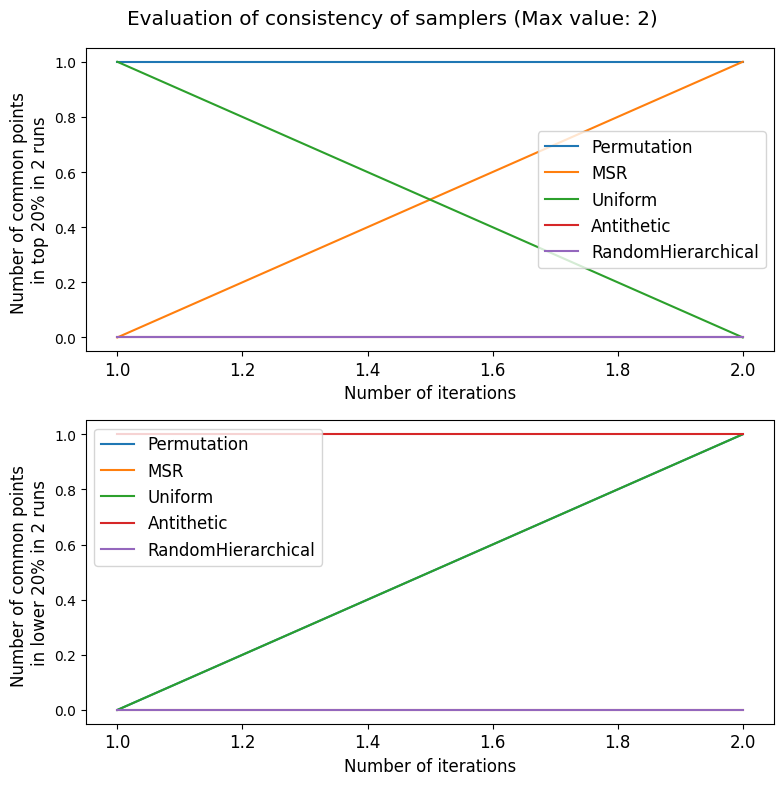

In [34]:
# Plot results

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for sampler_index, name in enumerate(names):
    axes[0].plot(max_checks, plot_results_top[sampler_index], label=name)
    axes[1].plot(max_checks, plot_results_low[sampler_index], label=name)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Number of iterations")
axes[1].set_xlabel("Number of iterations")
axes[0].set_ylabel(f"Number of common points \nin top 20% in {num_retries} runs")
axes[1].set_ylabel(f"Number of common points \nin lower 20% in {num_retries} runs")
fig.suptitle(f"Evaluation of consistency of samplers (Max value: {twenty_percent})")
fig.tight_layout()
plt.show()

**Conclusion:**
MSR